In [22]:
from tensorflow.keras.datasets import mnist

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, accuracy_score
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [24]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [25]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [26]:
x_train = x_train.reshape(-1,28*28).astype(np.float32)
x_test = x_test.reshape(-1,28*28).astype(np.float32)


In [27]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [28]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

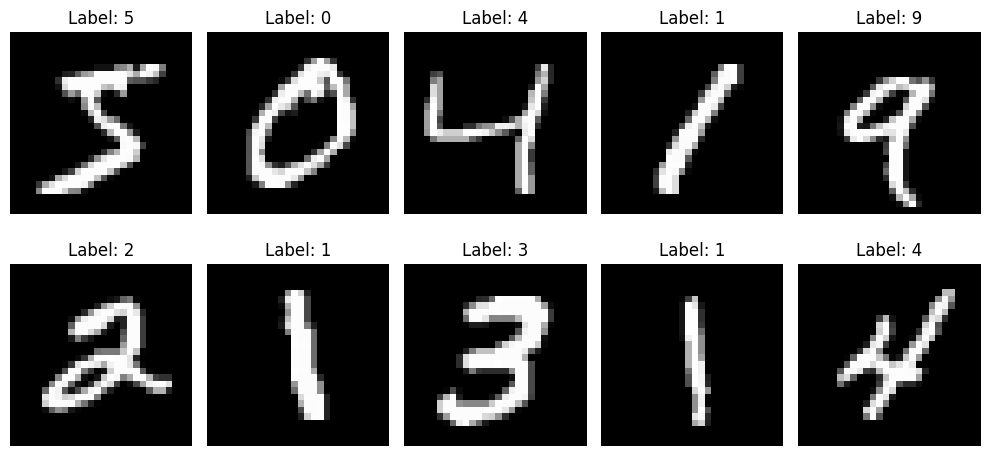

In [29]:
fig, axes = plt.subplots(2,5, figsize=(10,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i].reshape(28,28), cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [30]:
clf = LinearSVC(dual=False, max_iter = 5)
clf.fit(x_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=False, max_iter=5)

In [31]:
y_pred = clf.predict(x_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9135


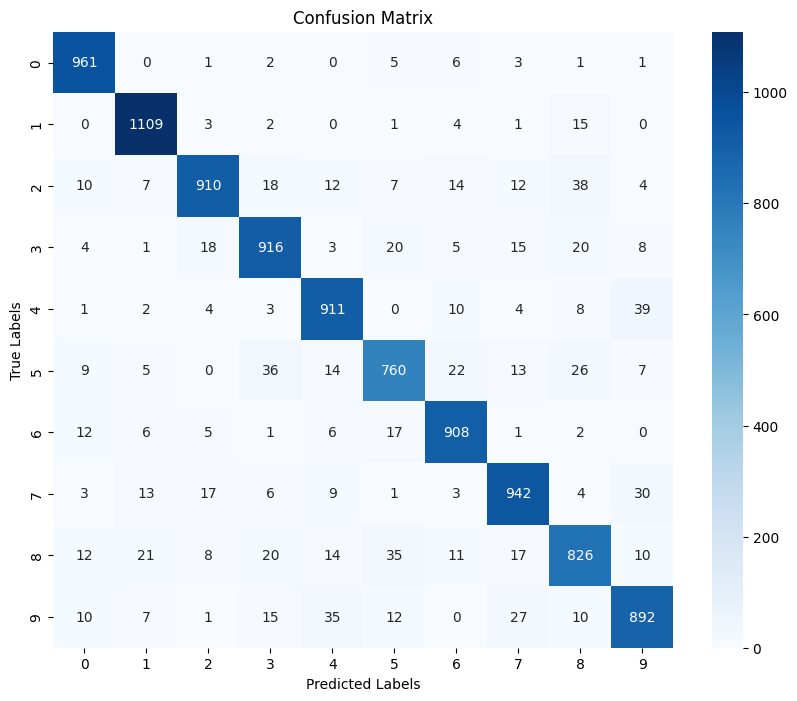

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [33]:

misclassified_indices = np.where(y_pred != y_test)[0]

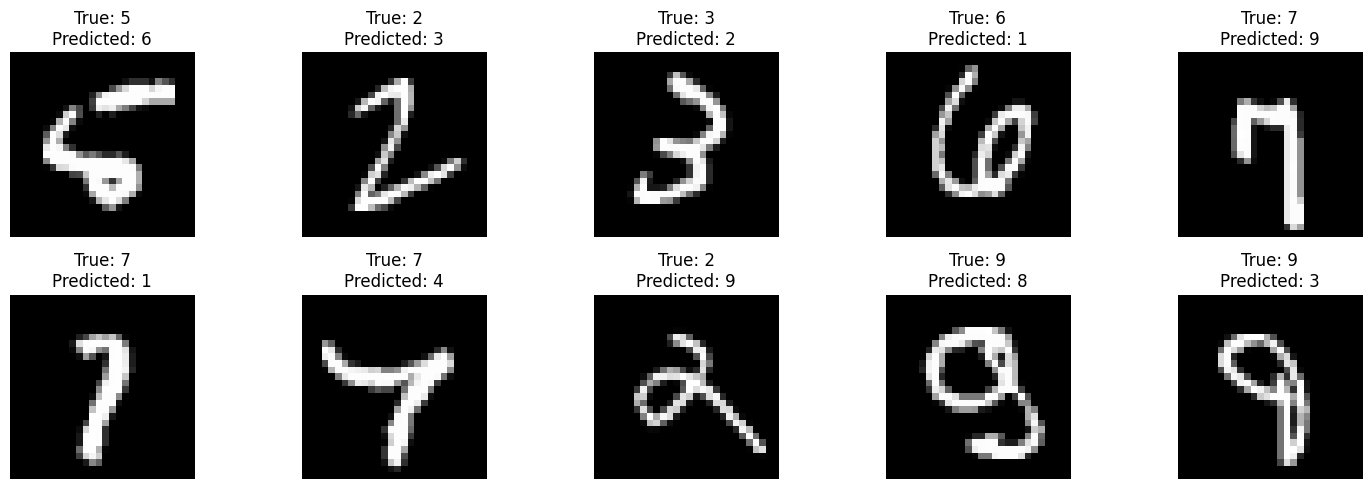

In [34]:
plt.figure(figsize=(15,5))
for i,index in enumerate(misclassified_indices[:10]):
  plt.subplot(2, 5, i+1)
  plt.imshow(x_test[index].reshape(28,28), cmap='gray')
  plt.title(f"True: {y_test[index]}\nPredicted: {y_pred[index]}")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [35]:
weights = clf.coef_
biases = clf.intercept_
print(weights.shape, biases)

(10, 784) [-1.96199376 -2.31259378 -1.58765463 -1.71104217 -2.14294249 -1.74907994
 -1.84196768 -2.00040177 -1.47624036 -1.83919935]


In [36]:
max_val = np.abs(weights).max()#so the weights dont directly go to zero
scalle = max_val/127.0
weights_int8 = weights.astype(np.int8) #round our weights to scale
with open("svm_model_mnist.h", "w") as f:
    f.write(f"#define NUM_CLASSES {weights.shape[0]}\n")
    f.write(f"#define NUM_FEATURES {weights.shape[1]}\n\n")


    f.write("double weights[NUM_CLASSES][NUM_FEATURES] = {\n") #double -> int8_t
    for row in weights_int8: # _int8
        #f.write("    {"+",".join(f"{v:.10f}" for v in row) + "},\n")
        f.write("  { " + ", ".join(str(v) for v in row) + " },\n")
    f.write("};\n\n")

    f.write("double bias[NUM_CLASSES] = {"+", ".join(f"{b:.10f}" for b in biases) + "};\n") #can also chane biases

print("Exported SVM model to svm_model_mnist.h")

Exported SVM model to svm_model_mnist.h


In [37]:
mean= scaler.mean_ #if ram req. is not met, we can change these as well
max_mean = np.abs(mean).max()
#scale = scaler.scale_
scale = max_mean/127.0
mean_int8 = np.round(mean/scale).astype(np.int8)
op_scale = scaler.scale_
max_scale = np.abs(op_scale).max()
scale_int8 = np.round(op_scale/max_scale).astype(np.int8)

with open("scaler.h", "w") as f:
    f.write(f"#define NUM_FEATURES {len(mean)}\n\n")

    f.write("double scaler_mean[NUM_FEATURES] = {\n")  #double -> int8_t
    #f.write("    " + ", ".join(f"{m:.10f}" for m in mean) + "\n")
    f.write("    " + ", ".join(f"{m:.10f}" for m in mean_int8) + "\n")
    f.write("};\n\n")

    f.write("double scaler_std[NUM_FEATURES] = {\n")  #double -> int8_t
    #f.write("    " + ", ".join(f"{s:.10f}" for s in scale) + "\n")
    f.write("    " + ", ".join(f"{s:.10f}" for s in scale_int8) + "\n")
    f.write("};\n")


print("Exported scaler parameters to scaler.h")

Exported scaler parameters to scaler.h


In [38]:
NUM_IMAGES_TO_EXPORT = 10

In [39]:
assert x_test_scaled.shape[1] == 784
x_sample = x_test[:NUM_IMAGES_TO_EXPORT]
y_sample = y_test[:NUM_IMAGES_TO_EXPORT]


In [40]:
def export_test_images_to_c(images, labels, filename="test_images.h"):
    num_images, num_features = images.shape
    with open(filename, "w") as f:
        f.write("#ifndef TEST_IMAGES_H\n#define TEST_IMAGES_H\n\n")
        f.write(f"#define NUM_TEST_IMAGES {num_images}\n")
        f.write(f"#define NUM_FEATURES {num_features}\n\n")

        # Write image data
        f.write("float test_images[NUM_TEST_IMAGES][NUM_FEATURES] = {{\n")
        for img in images:
            #f.write("  { " + ", ".join(f"{px:.6f}" for px in img) + " },\n")
            f.write("  { " + ", ".join(str(px) for px in img) + " },\n")
        f.write("};\n\n")

        # Write labels (as integers)
        f.write("int test_labels[NUM_TEST_IMAGES] = {\n")
        f.write("  " + ", ".join(str(label) for label in labels))
        f.write(" };\n\n")

        f.write("#endif // TEST_IMAGES_H\n")
    print(f"Exported {num_images} test images to {filename}")

In [41]:
export_test_images_to_c(x_sample, y_sample, "test_images.h")

Exported 10 test images to test_images.h
